In [27]:
from google.colab import drive
drive.mount('/content/drive')

import random
import copy
import csv
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install sentencepiece
import sentencepiece as spm

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
data_path = '/content/drive/MyDrive/Colab Notebooks/chatClassifier/KakaoTalkChats.txt'

def txt_to_lst(lst):
    time_period_flag = False
    with open(data_path, 'r') as f:
        for line in tqdm(f.readlines()):
            line = line.strip()

            if line[:len(start_date)]==start_date:
                time_period_flag = True

            if time_period_flag==True and line[:len(tda_end_date)]==tda_end_date:
                break

            if time_period_flag==True:
                if line[:2] == '20' and '년' in line and '월' in line and '일' in line and ('오전' in line or '오후' in line) and line.count(':') == 2:

                    index_comma = line.index(',')
                    index_colon = line.index(':', index_comma)
                    name = line[index_comma+2:index_colon-1]

                    text = line[index_colon+2:]
                    lst.append([name, text])

In [29]:
start_date = '2022년 1월 1일'
tda_end_date = '2023년 1월 1일'

train_lst = []
txt_to_lst(train_lst)
len(train_lst)

 98%|█████████▊| 3032549/3097114 [00:04<00:00, 629238.64it/s]


960588

In [30]:
train_df = pd.DataFrame(train_lst, columns=['name', 'text'])

In [31]:
counts = train_df['name'].value_counts()
counts_df = counts.sort_values(ascending=False).reset_index()
counts_df.columns = ['name', 'count']

bot_index = list(counts_df['name']).index("방장봇")
participants = list(counts_df['name'][:bot_index+1])
print(len(participants))
counts_df = counts_df[counts_df['name'].isin(participants)]

counts_df['index'] = counts_df.index
counts_df = counts_df.drop(columns=['count'])
name2index = counts_df.set_index('name').to_dict()['index']
index2name = counts_df.set_index('index').to_dict()['name']

62


In [32]:
print(name2index)
print(index2name)

{'爱德华/잠실르엘판매중/25': 0, '랄프': 1, '박찬홍/ 주생아/엉아들 잘부탁해~': 2, 'Dool Lee/도시빈민/외노자': 3, '원정': 4, '안정현 / 도태솔로': 5, '李在明/중앙대/인천/의원': 6, '라테라테': 7, '이상덕/울면서기도하는남쟈': 8, 'Jinyoung. woo': 9, '심언니': 10, '돌돌삼/머구/다주택': 11, 'Jihan/악성부채인생/겨울이길다': 12, 'Min Kim': 13, '정대만': 14, 'DG': 15, '이준국': 16, 'kich': 17, '오징어': 18, '최재경': 19, '지수/내년 시드 2chb 목표': 20, '촉촉': 21, '민수': 22, '리플 / 이정우': 23, '김반포': 24, '강영광': 25, '호빵': 26, '🌸슈롱': 27, '홍': 28, '지성원': 29, '송준기/망천/경자야~~': 30, '권인호': 31, 'malarka': 32, 'kim hs': 33, 'Jin': 34, '장재원': 35, '엔젤': 36, '밍기찡': 37, '곽병민': 38, '스갱🐻니니': 39, '퐝호': 40, '김동석': 41, 'Edward Jeong': 42, '최원규': 43, '박준권/서울/매일힘든남자': 44, '최주명': 45, '김민중/골프포기': 46, 'Jack Kim': 47, '김선광': 48, 'jiwon / 평촌': 49, '김종익': 50, '박경용': 51, '박용석': 52, '우천': 53, 'Dongwhane Lee': 54, '고기윤/일산': 55, '김승용': 56, 'John Perry': 57, '은경': 58, 'Myunee': 59, '박건령': 60, '방장봇': 61}
{0: '爱德华/잠실르엘판매중/25', 1: '랄프', 2: '박찬홍/ 주생아/엉아들 잘부탁해~', 3: 'Dool Lee/도시빈민/외노자', 4: '원정', 5: '안정현 / 도태솔로', 6: '李在明/중앙대/인천/의원', 7: '라테라테', 8:

In [33]:
train_df = train_df[train_df['name'].isin(participants)]
len(train_df)

938634

In [34]:
start_date = '2023년 1월 1일'
tda_end_date = '2023년 2월 1일'

test_lst = []
txt_to_lst(test_lst)
len(test_lst)

100%|█████████▉| 3094946/3097114 [00:02<00:00, 1462411.39it/s]


53026

In [35]:
test_df = pd.DataFrame(test_lst, columns=['name', 'text'])

In [36]:
test_df = test_df[test_df['name'].isin(participants)]
len(test_df)

51303

In [37]:
with open('gom22.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['text']))

In [38]:
spm.SentencePieceTrainer.Train('--input=gom22.txt --model_prefix=gom22 --vocab_size=10000 --model_type=bpe --max_sentence_length=100')

In [39]:
vocab_list = pd.read_csv('gom22.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print(len(vocab_list))
vocab_list.sample(10)

10000


,0,1
5992,▁얘는,-5989
1013,건가,-1010
1519,▁묵,-1516
4264,ich,-4261
5343,▁도로,-5340
7417,▁연락주세요,-7414
960,적인,-957
5201,호텔,-5198
4022,▁성님덜,-4019
2748,▁불가능,-2745


In [40]:
sp = spm.SentencePieceProcessor()
vocab_file = "gom22.model"
sp.load(vocab_file)

True

In [41]:
test_shuffle = copy.deepcopy(test_lst)
random.shuffle(test_shuffle)
for line in test_shuffle[:3]:
    print(line[1])
    print(sp.encode_as_pieces(line[1]))
    print(sp.encode_as_ids(line[1]))
    print()

그냥 검사후 자격만되면 주는줄
['▁그냥', '▁검사', '후', '▁자격', '만', '되면', '▁주는', '줄']
[172, 2006, 8093, 6693, 7902, 1045, 3185, 8127]

서민금융쪽의 전문성은 학문보다는 관심도에 비례하고
['▁서민', '금융', '쪽', '의', '▁전문', '성은', '▁학', '문', '보다는', '▁관심', '도', '에', '▁비례', '하고']
[2268, 5537, 8306, 7929, 1631, 2547, 582, 8001, 2080, 1512, 7874, 7873, 7370, 109]

(살려주세요)
['▁(', '살', '려', '주세요', ')']
[290, 8021, 7975, 970, 8144]



In [42]:
train_name = train_df['name'].values.tolist()
y_train = []
for y in train_name:
    y_train.append(name2index[y])

train_text = train_df['text'].values.tolist()
X_train = []
for X in train_text:
    X_train.append(sp.encode_as_ids(X))

In [43]:
print(len(X_train))
print(len(y_train))

938634
938634


In [44]:
test_name = test_df['name'].values.tolist()
y_test = []
for y in test_name:
    y_test.append(name2index[y])

test_text = test_df['text'].values.tolist()
X_test = []
for X in test_text:
    X_test.append(sp.encode_as_ids(X))

In [45]:
print(len(X_test))
print(len(y_test))

51303
51303


388
6.092775245729432


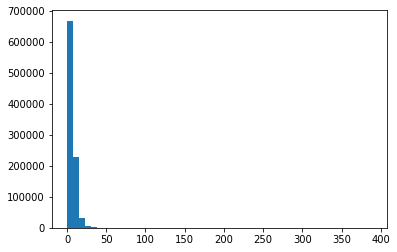

In [46]:
print(max(len(X) for X in X_train))
print(sum(map(len, X_train))/len(X_train))

plt.hist([len(X) for X in X_train], bins=50)
plt.show()

In [47]:
pad_maxlen = 25
count = 0
for X in X_train:
    if len(X)<=pad_maxlen:
        count += 1
print(count/len(X_train))

0.9919212387362912


In [48]:
X_train = pad_sequences(X_train, maxlen=pad_maxlen)
y_train = np.array(y_train)
y_train = to_categorical(y_train, len(participants))
print(y_train.shape)

X_test = pad_sequences(X_test, maxlen=pad_maxlen)
y_test = np.array(y_test)
y_test = to_categorical(y_test, len(participants))
print(y_test.shape)

(938634, 62)
(51303, 62)


In [49]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [50]:
model_input = Input(shape=(pad_maxlen,))
z = Embedding(len(vocab_list), 
              embedding_dim, 
              input_length=pad_maxlen, 
              name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [51]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [52]:
z = Concatenate()(conv_blocks) if len(conv_blocks)>1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(len(participants), activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('gom22.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.21691, saving model to gom22.h5
11733/11733 - 58s - loss: 3.1317 - acc: 0.2038 - val_loss: 3.0349 - val_acc: 0.2169 - 58s/epoch - 5ms/step
Epoch 2/10

Epoch 2: val_acc improved from 0.21691 to 0.24001, saving model to gom22.h5
11733/11733 - 56s - loss: 2.9627 - acc: 0.2415 - val_loss: 2.9951 - val_acc: 0.2400 - 56s/epoch - 5ms/step
Epoch 3/10

Epoch 3: val_acc improved from 0.24001 to 0.25170, saving model to gom22.h5
11733/11733 - 56s - loss: 2.9231 - acc: 0.2508 - val_loss: 3.0006 - val_acc: 0.2517 - 56s/epoch - 5ms/step
Epoch 4/10

Epoch 4: val_acc did not improve from 0.25170
11733/11733 - 55s - loss: 2.9048 - acc: 0.2563 - val_loss: 3.0236 - val_acc: 0.2407 - 55s/epoch - 5ms/step
Epoch 5/10

Epoch 5: val_acc improved from 0.25170 to 0.25285, saving model to gom22.h5
11733/11733 - 56s - loss: 2.8933 - acc: 0.2599 - val_loss: 3.0364 - val_acc: 0.2529 - 56s/epoch - 5ms/step
Epoch 6/10

Epoch 6: val_acc did not improve from 0.25285


In [55]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/chatClassifier/gom22.h5')
print(f"Test accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}")

1604/1604 [==============================] - 4s 2ms/step - loss: 2.8331 - acc: 0.2918
Test accuracy: 0.2918


In [67]:
r = random.randint(0, len(X_test))
X = X_test[r]
X_lst = X.tolist()
pieces = []
for i in X_lst:
    if i!=0:
        pieces.append(sp.IdToPiece(i))

sentence = ''.join(i for i in pieces)
sentence = sentence.replace('▁', ' ')
if sentence[0]==' ':
    sentence = sentence[1:]
print(sentence)

X = np.expand_dims(X, axis=0)
pred = loaded_model.predict(X)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

다 없어졌.
1/1 [==============================] - 0s 16ms/step
1) 권인호: 38.04%
2) 랄프: 18.75%
3) 박찬홍/ 주생아/엉아들 잘부탁해~: 7.05%
4) Edward Jeong: 4.65%
5) 라테라테: 3.86%


In [72]:
sentence = '존예디컵 여름 풀파티 하기 딱이긴 하겠네요'
print(sentence)

sentence = [sp.encode_as_ids(sentence)]
sentence = pad_sequences(sentence, maxlen=pad_maxlen)
pred = loaded_model.predict(sentence)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

존예디컵 여름 풀파티 하기 딱이긴 하겠네요
1/1 [==============================] - 0s 19ms/step
1) 爱德华/잠실르엘판매중/25: 54.91%
2) Jinyoung. woo: 7.72%
3) 정대만: 4.46%
4) 심언니: 4.13%
5) kich: 2.99%
